In [4]:
# 图平滑度
from datasets import MilanFG
from utils.funcs import AdjMat2LapMat
import networkx as nx
import numpy as np
import torch
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform
from utils.smoothGL import gsp_learn_graph_log_degrees, LogModel


milan_dataset = MilanFG(format="graphlearnvae",  #'mywat',
                        batch_size=32,
                        aggr_time=None,
                        time_range='all',
                        close_len = 6, # => Xc (stgcn)
                        period_len = 0, # => Xp (stgcn)
                        trend_len = 0, # => Xt (stgcn)
                        pred_len = 3,
                        )
milan_dataset.prepare_data()
milan_dataset.setup()
train_dl = milan_dataset.train_dataloader()

crawled_feature.csv already exists in /data/scratch/jiayin
milan_10min_T_N_5.h5 already exists in /data/scratch/jiayin
crawled_feature.csv already exists in /data/scratch/jiayin
milan_10min_T_N_5.h5 already exists in /data/scratch/jiayin
loaded meta of shape: (4, 20, 20) 
Loading Milan data...
loaded data shape:  (8496, 1, 20, 20)


In [ ]:
import pandas as pd
temporal_graph = True

if temporal_graph:
    batch = next(iter(train_dl))
    X, Y = batch
    X = X.reshape(X.shape[0]*X.shape[1], X.shape[2])
    # Batch X shape: torch.Size([32, 400, 6])
    # Batch Y shape: torch.Size([32, 400, 6])
else:
    X = milan_dataset.milan_train
    X = X.reshape(X.shape[0], X.shape[1], X.shape[2]*X.shape[3]).squeeze()
    X = torch.tensor(X, dtype=torch.float) # [T, N]
    X = X.t()
# GLlog_model = LogModel(avg_degree=80,
#                        alpha=1,  # 1e3
#                        beta=1,  # 1e-4
#                       )
# GLlog_model.fit(X.numpy())
# A_unnorm = GLlog_model.weights_

# dist_vec = pdist(X.t()) ** 2  # X_data.shape=(dim, n_nodes)
# A_unnorm = gsp_learn_graph_log_degrees(dist_vec, alpha=1e4, beta=1e-4)

# A_unnorm = nx.adjacency_matrix(nx.grid_2d_graph(20, 20))
# A_unnorm = nx.adjacency_matrix(nx.erdos_renyi_graph(400,  3.8/400, seed=42))
# A_unnorm = np.load("/data/scratch/jiayin/AdjKnn2_D15_Milan10Min_Internet.npy")
A_unnorm = pd.read_csv("/home/jiayin/PycharmProjects/Spatio-Temporal-Analysis-Telecom-Italia/experiments/experiments/results/GLLowPass_Temporal_04142037/A.csv").to_numpy()
# A_unnorm = nx.adjacency_matrix(nx.barabasi_albert_graph(400, 2, seed = 31))

L = AdjMat2LapMat(A_unnorm, normalized=True)
# A = Adj2EdgeList(A_unnorm) # edge index

smooth_x = torch.trace(X @ L @ X.t() )
scale_x = torch.trace(X @ X.t() )
val_x = smooth_x / scale_x
print(f"Average X smoothness across all batches: {val_x:.4f}")

# np.save("/data/scratch/jiayin/Adj_SmoothGL_Milan10Min_Internet.npy", A_unnorm)
degrees = (A_unnorm > 0).sum(axis=1)
print("Estimated average degree:", degrees.mean())


#### spatial graph
grid graph: 0.0911, average degree = 3.8

saved smooth graph: 0.0754, average degree = 73.505

lowpass graph: 0.2005, average degree = 17.295

#### temporal graph
low pass graph: smooth = 0.03, average degree = 4.6

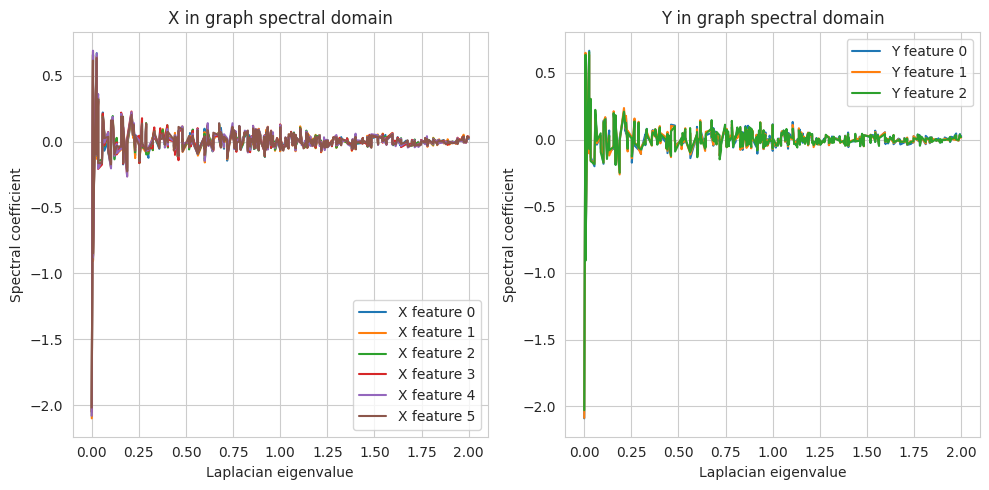

In [10]:
import torch
import matplotlib.pyplot as plt

# 1. 获取第一个batch
train_dl = milan_dataset.train_dataloader()  # len(train_dl)=213
first_batch = next(iter(train_dl))  # 直接取第一个batch
X_batch, Y_batch = first_batch    # X_batch: [32, 400, 6], Y_batch: [32, 400, 3]

# 2. 取batch内的第一个样本
#   X: [400, 6], Y: [400, 3]
X0 = X_batch[0]  # shape=[400,6]
Y0 = Y_batch[0]  # shape=[400,3]

# 假设已经有图的拉普拉斯矩阵 L: [400, 400]
# 注意要和 X0, Y0 在同一device和dtype
L = L.float()  # 如果需要的话
# 如果你在GPU上:
# device = torch.device("cuda")
# X0, Y0 = X0.to(device), Y0.to(device)
# L = L.to(device)

# 3. 对 L 做特征分解 (对称实矩阵可用 torch.linalg.eigh)
eigenvals, U = torch.linalg.eigh(L)  # eigenvals=[400], U=[400,400]

# 4. 将 X0, Y0 转到谱域: X_hat = U^T X0, Y_hat = U^T Y0
#   先把 X0, Y0 视作 [400, features]
#   计算维度匹配: U^T -> [400,400], X0 -> [400,6] => X_hat->[400,6]
X_hat = U.t() @ X0
Y_hat = U.t() @ Y0

# 5. 画图 - 在同一个figure里，左半边画 X 的多个特征，右半边画 Y 的多个特征
plt.figure(figsize=(10,5))

# 横坐标是拉普拉斯特征值 eigenvals (从小到大)
# eigenvals.shape = [400]
# X_hat.shape = [400,6], Y_hat.shape = [400,3]

# 子图1: X 的谱域分量
plt.subplot(1,2,1)
for f in range(X_hat.shape[1]):  # 6个特征
    plt.plot(eigenvals.cpu().numpy(), X_hat[:, f].cpu().numpy(), label=f"X feature {f}")
plt.xlabel("Laplacian eigenvalue")
plt.ylabel("Spectral coefficient")
plt.title("X in graph spectral domain")
plt.legend()

# 子图2: Y 的谱域分量
plt.subplot(1,2,2)
for f in range(Y_hat.shape[1]):  # 3个特征
    plt.plot(eigenvals.cpu().numpy(), Y_hat[:, f].cpu().numpy(), label=f"Y feature {f}")
plt.xlabel("Laplacian eigenvalue")
plt.ylabel("Spectral coefficient")
plt.title("Y in graph spectral domain")
plt.legend()

plt.tight_layout()
plt.show()

In [1]:
# 初始化 MyWAT，测试
from models.MyWAT import MySingleWAT
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

model = MySingleWAT(N=400,input_time_steps=128,K=16,L=32).cuda()
dummy_input = torch.randn(32, 400, 128).cuda()
target = torch.randn(32, 400, 32).cuda()
# 假设你的模型有一个损失函数
criterion = torch.nn.MSELoss()

# 创建一个优化器
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 模拟前向传播和计算损失
output,_ = model(dummy_input)  # 模型的前向传播
loss = criterion(output, target)  # 计算损失

# 反向传播，计算梯度
loss.backward()

result = model._compute_forward_results(dummy_input)


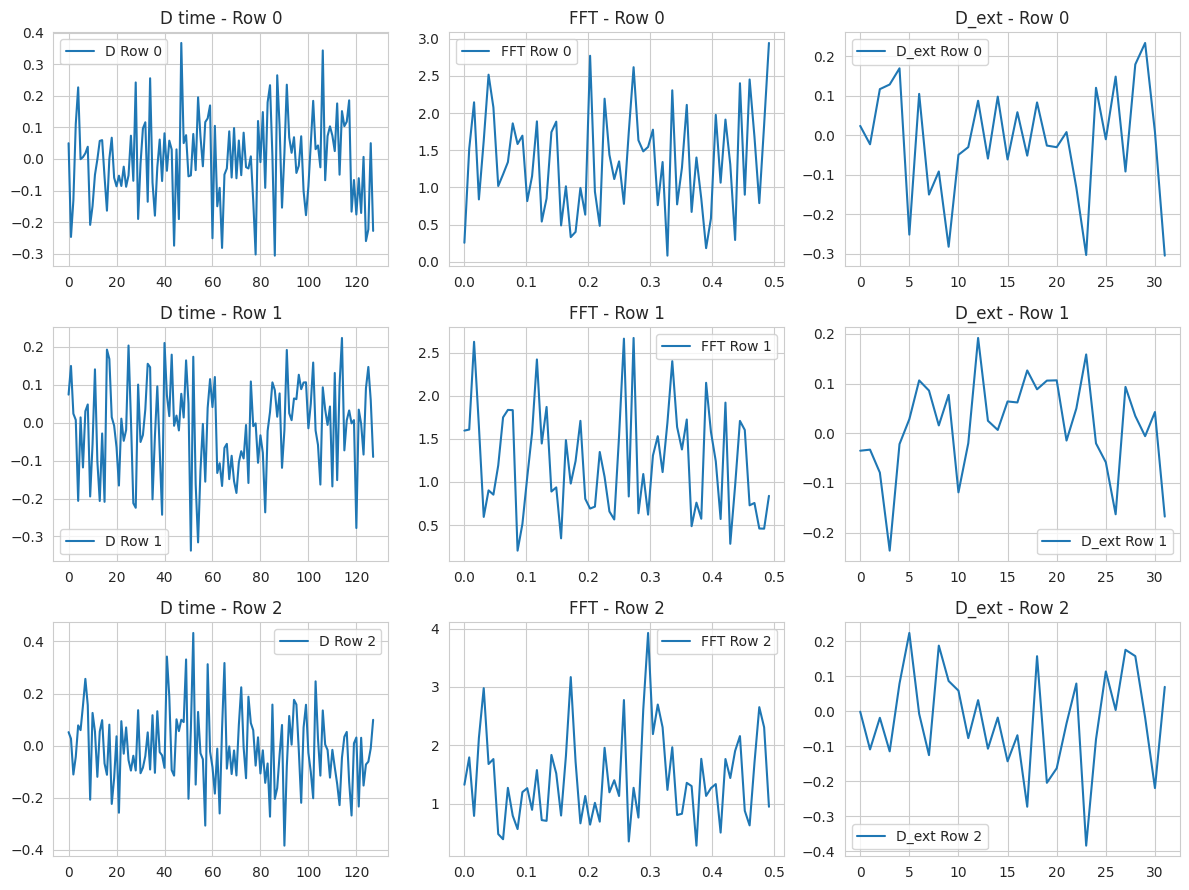

In [2]:
D, D_ext = result["D"], result["D_ext"]

# ✅ 生成第一张图（D, D_ext 的 1,5,10行）
fig_D, axes_D = plt.subplots(nrows=3, ncols=3, figsize=(12, 9))

rows_to_plot = [0, 1, 2]  # 需要绘制的行索引
for i, row in enumerate(rows_to_plot):
    axes_D[i, 0].plot(D[row, :].cpu().detach().numpy(), label=f'D Row {row}')
    axes_D[i, 0].grid(True)
    axes_D[i, 0].set_title(f'D time - Row {row}')
    axes_D[i, 0].legend()

    # 计算 FFT 变换
    time_series = D[row, :].cpu().detach().numpy()
    fft_values = np.fft.fft(time_series)  # 计算 FFT
    fft_magnitudes = np.abs(fft_values)  # 计算振幅
    fft_frequencies = np.fft.fftfreq(len(time_series))  # 计算频率轴
    # 画频域信号（右列）
    axes_D[i, 1].plot(fft_frequencies[:len(fft_frequencies)//2], fft_magnitudes[:len(fft_magnitudes)//2], label=f'FFT Row {row}')
    axes_D[i, 1].grid(True)
    axes_D[i, 1].set_title(f'FFT - Row {row}')
    axes_D[i, 1].legend()

    axes_D[i, 2].plot(D_ext[row, :].cpu().detach().numpy(), label=f'D_ext Row {row}')
    axes_D[i, 2].grid(True)
    axes_D[i, 2].set_title(f'D_ext - Row {row}')
    axes_D[i, 2].legend()

plt.tight_layout()
plt.show()
plt.close()

In [ ]:
# 初始化 MyWAT，测试
from models.MyWAT import MySingleWAT, MyDualWAT
import torch

model = MySingleWAT.load_from_checkpoint("/home/jiayin/PycharmProjects/Spatio-Temporal-Analysis-Telecom-Italia/experiments/lightning_logs/WAT_Embed_TrainExt_128_32_03241430/checkpoints/epoch=168-step=35152.ckpt")

print(model.basis_extraction.sigmoid_diff.k)
print(model.basis_extraction.sigmoid_diff.start_idx)


In [1]:
import os
import pandas as pd
import torch
from timm.data.auto_augment import color
from torchvision.utils import save_image

im_res_path = '/home/jiayin/PycharmProjects/Spatio-Temporal-Analysis-Telecom-Italia/experiments/experiments/results'

run_id = 'WAT_Tem_DiagA_6_6_04102046'
file_name_C = 'C_matrix.csv'
file_name_C_pre = 'C_pre_matrix.csv'
file_name_D = 'D_matrix.csv'
file_name_D_ext = 'D_ext_matrix.csv'
file_name_A = 'A_matrix.csv'

C = pd.read_csv(os.path.join(im_res_path, run_id, file_name_C)).to_numpy()
C_pre = pd.read_csv(os.path.join(im_res_path, run_id, file_name_C_pre)).to_numpy()
D = pd.read_csv(os.path.join(im_res_path, run_id, file_name_D)).to_numpy()
D_ext = pd.read_csv(os.path.join(im_res_path, run_id, file_name_D_ext)).to_numpy()
A = pd.read_csv(os.path.join(im_res_path, run_id, file_name_A)).to_numpy()

In [ ]:
# 画 D 和 D-ext
import matplotlib.pyplot as plt

fig_D, axes_D = plt.subplots(nrows=3, ncols=2, figsize=(12, 9))
rows_to_plot = [0, 8, 15]  # 需要绘制的行索引
for i, row in enumerate(rows_to_plot):
    axes_D[i, 0].plot(D[row, :], label=f'D Row {row}')
    axes_D[i, 0].grid(True)
    axes_D[i, 0].set_title(f'D - Row {row}')
    axes_D[i, 0].legend()

    axes_D[i, 1].plot(D_ext[row, :], label=f'D_ext Row {row}')
    axes_D[i, 1].grid(True)
    axes_D[i, 1].set_title(f'D_ext - Row {row}')
    axes_D[i, 1].legend()

plt.tight_layout()
plt.show()

In [ ]:
# 画D和其fft
import numpy as np
import matplotlib.pyplot as plt

# 选择需要绘制的行索引
rows_to_plot = [0, 2, 10]

# 创建 3 行 2 列的子图
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 9))

for i, row in enumerate(rows_to_plot):
    # 获取时序数据
    time_series = D[row, :]

    # 画时序信号（左列）
    axes[i, 0].plot(time_series, label=f'D Row {row}')
    axes[i, 0].grid(True)
    axes[i, 0].set_title(f'Time Series - Row {row}')
    axes[i, 0].legend()

    # 计算 FFT 变换
    fft_values = np.fft.fft(time_series)  # 计算 FFT
    fft_magnitudes = np.abs(fft_values)  # 计算振幅
    fft_frequencies = np.fft.fftfreq(len(time_series))  # 计算频率轴
    # 画频域信号（右列）
    axes[i, 1].plot(fft_frequencies[:len(fft_frequencies)//2], fft_magnitudes[:len(fft_magnitudes)//2], label=f'FFT Row {row}')
    axes[i, 1].grid(True)
    axes[i, 1].set_title(f'FFT - Row {row}')
    axes[i, 1].legend()

plt.tight_layout()
plt.show()

(12800, 4)
(12800, 4)


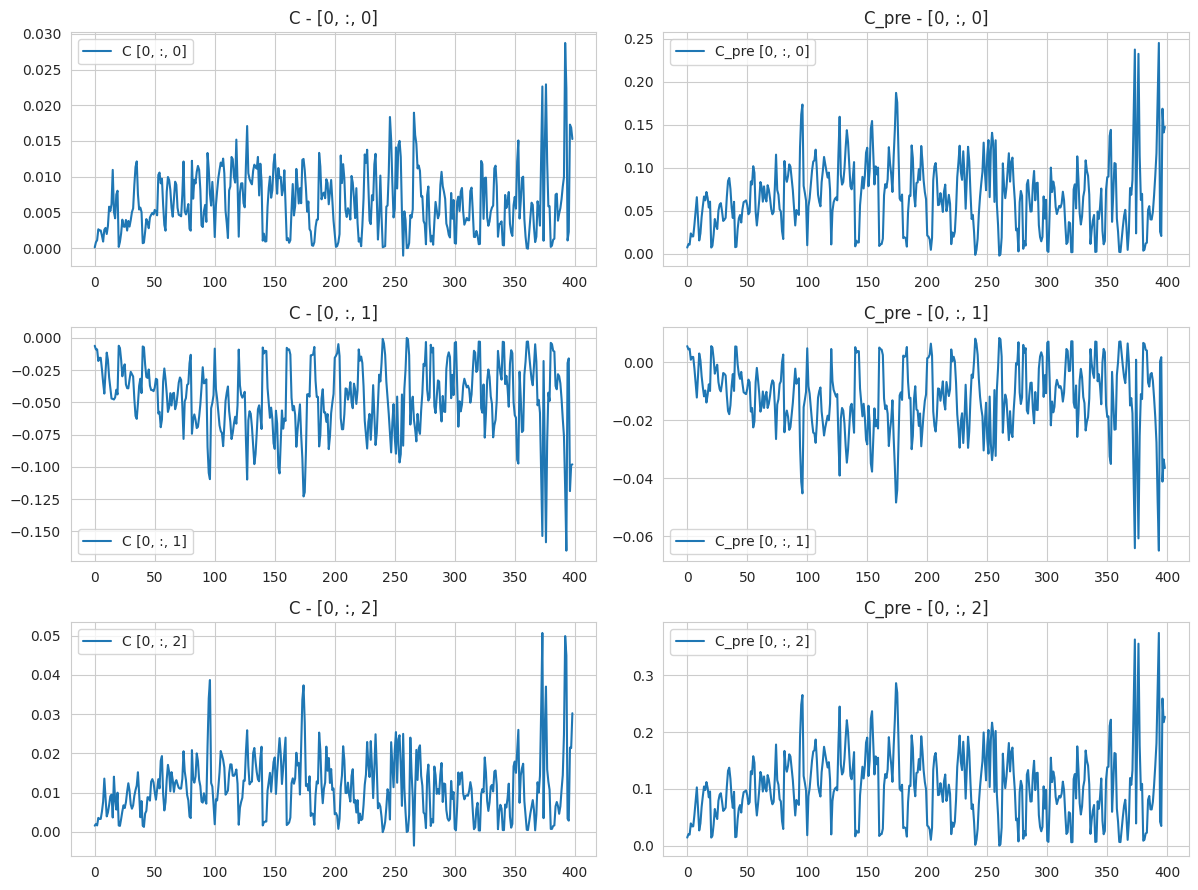

In [6]:
# 画系数C
import matplotlib.pyplot as plt

# C, C_pre = result['C'], result['C_pre']
print(C.shape)
print(C_pre.shape)
fig_C, axes_C = plt.subplots(nrows=3, ncols=2, figsize=(12, 9))

cols_to_plot = [0, 1, 2]
for i, col in enumerate(cols_to_plot):
    axes_C[i, 0].plot(C[0:399, col], label=f'C [0, :, {col}]')
    axes_C[i, 0].grid(True)
    axes_C[i, 0].set_title(f'C - [0, :, {col}]')
    axes_C[i, 0].legend()

    axes_C[i, 1].plot(C_pre[0:399, col], label=f'C_pre [0, :, {col}]')
    axes_C[i, 1].grid(True)
    axes_C[i, 1].set_title(f'C_pre - [0, :, {col}]')
    axes_C[i, 1].legend()

plt.tight_layout()
plt.savefig(os.path.join(im_res_path, run_id, "C_Cpre_plot.png"))
plt.show()

sum(A):  1401305.4045934605


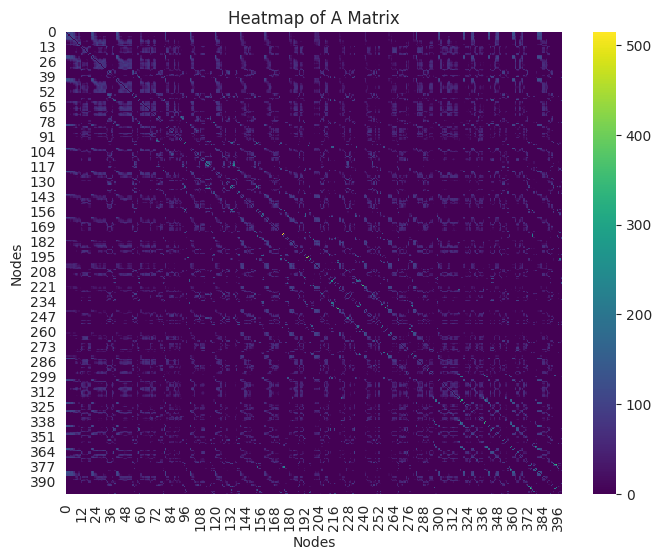

In [46]:
# 画A
import matplotlib.pyplot as plt
import seaborn as sns

# 创建热力图
plt.figure(figsize=(8, 6))  # 设置图像大小
sns.heatmap(A_unnorm, cmap="viridis", annot=False, cbar=True)

# 设置标题
plt.title("Heatmap of A Matrix")
plt.xlabel("Nodes")
plt.ylabel("Nodes")

# 显示图像
print('sum(A): ', np.sum(A_unnorm))
plt.show()

In [ ]:
# 查看提取函数
import torch
from models.MyWAT import SigmoidDiffWindow2D
import matplotlib.pyplot as plt

x = torch.ones(4,256)
sigmoid_func = SigmoidDiffWindow2D(K = 4, L = 128)
y = sigmoid_func(x)

print("sigmoid_func.start_idx shape: ", sigmoid_func.start_idx.shape)
print("sigmoid_func.start_idx elements: ", sigmoid_func.start_idx)

# plt.plot(sigmoid_func.window[0,:],marker='o',linestyle='-',color='r')
# plt.show()

fig_S, axes_S = plt.subplots(nrows=4, figsize=(12, 9))
cols_to_plot = [0,1,2,3]
for i, col in enumerate(cols_to_plot):
    axes_S[i].plot(sigmoid_func.window[col,:], label = f'{col}')
    axes_S[i].grid(True)
    axes_S[i].set_title(f'SigmoidDiffWindow2D [{col}, :]')
plt.tight_layout()
plt.show()